In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator , ClassifierMixin
import matplotlib.pyplot as plt

In [29]:
data = pd.read_csv("mnist_train.csv")

In [30]:
ytrain = data["label"]
Xtrain = data.drop(columns="label" , inplace=False)
ytrain = ytrain.values
Xtrain = Xtrain.values

Xtrain = Xtrain.reshape(-1 , 28 , 28 , 1)

In [31]:
from sklearn.model_selection import train_test_split

Xtrain , Xval , ytrain , yval = train_test_split(Xtrain , ytrain , test_size=0.005 , random_state=42)

In [25]:
class CNNClassifier(BaseEstimator , ClassifierMixin):
    def __init__(self , activation_conv=tf.nn.relu , activation = tf.nn.elu , log_dir = None
                , optimizer = tf.train.AdamOptimizer , learning_Rate = 0.001 , batch_norm = False , dropout = None):
        self.activation = activation
        self.activation_conv = activation_conv
        self.optimizer = optimizer
        self.learning_Rate = learning_Rate
        self.batch_norm = batch_norm
        self.dropout = dropout
        if (dropout is not None) or (batch_norm is True) :
            self.training = tf.placeholder_with_default(False , shape=())
        self._session = None
        self.log_dir = log_dir
    
    def get_model_params(self):
        with self.graph_.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name : self._session.run(gvar) for gvar in gvars}
    
    def restore_model_params(self , model_params):
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name : self.graph_.get_operation_by_name(gvar_name + "/Assign") for gvar_name in gvar_names}
        init_values = {gvar_name : assign_op.inputs[1] for gvar_name , assign_op in assign_ops.items()}
        self._session.run(assign_ops.values() , feed_dict={init_values[gvar_name] : model_params[gvar_name] for gvar_name in gvar_names})
    
    def save(self):
        saver.save( self.session_ , "/tmp/my_model.ckpt")
    
    def build_graph(self , graph):
        with graph.as_default():
            X = tf.placeholder(tf.float32 , shape=(None , 28 , 28 , 1) , name="X")
            y = tf.placeholder(tf.int32 , shape=(None) , name="y")

            inputs = X

            inputs = tf.layers.conv2d(inputs , filters = 5, activation=self.activation_conv , 
                                      kernel_size=5 , strides=[1,1] , padding="SAME" , name="Conv1")
            inputs = tf.layers.conv2d(inputs , filters = 10, activation=self.activation_conv , 
                                      kernel_size=3 , strides=[1,1] , padding="SAME" , name="Conv2")
            inputs = tf.layers.max_pooling2d(inputs , strides=[2,2] , padding="VALID" , pool_size=[2,2] , name="Pool1")
            inputs = tf.layers.conv2d(inputs , filters = 20, activation=self.activation_conv , 
                                      kernel_size=3 , strides=[1,1] , padding="SAME")
            inputs = tf.nn.local_response_normalization(inputs , depth_radius=2)
            inputs = tf.layers.max_pooling2d(inputs , strides=[2,2] , padding="VALID" , pool_size=[2,2] , name="Pool2")
            inputs = tf.layers.conv2d(inputs , filters = 50, activation=self.activation_conv , 
                                      kernel_size=5 , strides=[1,1] , padding="SAME")
            inputs = tf.layers.conv2d(inputs , filters = 100, activation=self.activation_conv , 
                                      kernel_size=3 , strides=[1,1] , padding="SAME")
            inputs = tf.layers.average_pooling2d(inputs , padding="VALID" , pool_size=7 , strides=1 , name="Global_Avg_Pool")
            inputs = tf.layers.flatten(inputs , name="Flatten")
            if self.dropout is not None :
                inputs = tf.layers.dropout(inputs , self.dropout , training=self.training , name="Dropout")
            inputs = tf.layers.dense(inputs , units=50 , activation=None ,
                                     kernel_initializer=tf.variance_scaling_initializer() , name="Hidden_Layer")
            if self.batch_norm:
                inputs = tf.layers.batch_normalization(inputs , momentum=0.9 , training = self.training , name="Batch Norm")
            inputs = self.activation(inputs)
            logits = tf.layers.dense(inputs , 10 , activation=None , kernel_initializer=tf.variance_scaling_initializer())

            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y , logits=logits)
            loss = tf.reduce_mean(loss , name="Loss")

            self.y_proba = tf.nn.softmax(logits , name = "Probabilities")
            accuracy = tf.reduce_mean(tf.cast(tf.math.in_top_k(logits , y , 1),tf.float32) , name="Accuracy")

            optimizer = self.optimizer()
            training_op = optimizer.minimize(loss)
            if self.batch_norm :
                training_op = [ training_op , tf.get_collection(tf.GraphKeys.UPDATE_OPS)]

            self.init = tf.global_variables_initializer()
            self.saver = tf.train.Saver()
            self.X_ = X 
            self.y_ = y
            self.training_op = training_op
            self.accuracy = accuracy
            self.loss = loss

    def fit(self , Xtrain , ytrain ,Xval = None , yval = None ,  batch_size = 50 , n_epoch = 10):
        self.close_session()
        
        self.graph_ = tf.get_default_graph()
        tf.reset_default_graph()
        
        num_examples = Xtrain.shape[0]
        Xreshaped = Xtrain.reshape( [ num_examples , 28 , 28 , 1 ] )
        
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_acc = 0
        best_params = None
        
        self.build_graph(graph = self.graph_)
        self._session = tf.Session(graph=self.graph_)
        
        if Xval is not None and yval is not None:
            feed_dict_val = {self.X_ : Xval , self.y_:yval}
        else :
            feed_dict_val = None
        
        with self._session.as_default() as sess :
            sess.run(self.init)
            for epoch in range(n_epoch):
                perms = np.random.permutation(num_examples)
                Xbatches = np.array_split(Xreshaped[perms] , num_examples // batch_size)
                ybatches = np.array_split(ytrain[perms] , num_examples // batch_size )
                for Xbatch , ybatch in zip(Xbatches , ybatches):
                    feed_dict = {self.X_:Xbatch , self.y_:ybatch}
                    if self.batch_norm or self.dropout :
                        feed_dict[self.training] = True
                    sess.run(self.training_op , feed_dict=feed_dict)
                    
                    if feed_dict_val :
                        acc = self.accuracy.eval(feed_dict = feed_dict_val)
                    else :
                        if self.batch_norm or self.dropout :
                            feed_dict[self.training] = False
                        acc = self.accuracy.eval(feed_dict)
                    if acc > best_acc:
                        best_acc = acc
                        best_params = self.get_model_params()
                print("Epoch {} Accuracy : {} | Best : {}".format(epoch + 1 , acc , best_acc))
            
            self.restore_model_params(best_params)
            return
        
    def close_session(self):
        if self._session:
            self._session.close()
    def predict(self , X):
        return np.argmax(self.predict_proba(X) , axis=1)
    def predict_proba(self , X):
        if self._session :
            return self._session.run(self.y_proba , feed_dict = {self.X_:X})
        else:
            raise NotFittedError("Not Fitted Yet")

In [32]:
Xtrain = Xtrain[:50000]
ytrain = ytrain[:50000]
Xval = Xval[:100]
yval = yval[:100]

In [33]:
Xtrain.shape

(50000, 28, 28, 1)

In [34]:
Xval.shape

(100, 28, 28, 1)

In [35]:
clf = CNNClassifier()
clf.fit(Xtrain , ytrain, Xval , yval , 50 , 2)

Epoch 1 Accuracy : 0.9700000286102295 | Best : 0.9700000286102295


KeyboardInterrupt: 

In [36]:
def checker(img):
    plt.imshow(img.reshape([28 , 28]))
    plt.show()
    print(clf.predict(img.reshape([-1 , 28 , 28 , 1])))

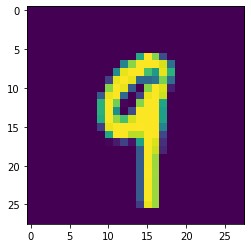

[9]


In [37]:
checker(Xtrain[0])

In [39]:
clf.saver.save(clf._session , "/tmp/model.ckpt")

'/tmp/model.ckpt'

In [40]:
clf.close_session()